In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('merged_feret_train.csv')
generated_df = pd.read_csv('feret_generated_2.csv')
df = pd.concat([df, generated_df], ignore_index=True)

DATA_DIR = "./colored/"
TRAIN_TEST_SPLIT = 0.9
IM_WIDTH = 100
IM_HEIGHT = 100
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'hispanic', 4: 'middle eastern'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP



({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'hispanic', 4: 'middle eastern'},
 {'white': 0, 'black': 1, 'asian': 2, 'hispanic': 3, 'middle eastern': 4})

In [3]:
# for unfair test

p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: gender)
df['race_id'] = df['race'].map(lambda race: race)
len(train_idx), len(valid_idx), len(test_idx)

(624, 268, 100)

In [11]:
# for fair test
test_df = pd.read_csv('merged_feret_test.csv')

In [12]:
# for fair test
p = np.random.permutation(len(df))
train_up_to = int(len(df))
train_idx = p[:train_up_to]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: gender)
df['race_id'] = df['race'].map(lambda race: race)

len(train_idx), len(valid_idx)

(694, 298)

In [4]:
root_path = "./colored/"
generation_path = "./feret_all/"
df['file'] = df['filename'].apply(lambda x: os.path.join(root_path if "final" in x else generation_path, x))
df

,filename,gender,race,is_generated,gender_id,race_id,file
0,00823_940307_fa_a_converted_final.png,1,4,NaN,1,4,./colored/00823_940307_fa_a_converted_final.png
1,00855_940307_fa_converted_final.png,0,4,NaN,0,4,./colored/00855_940307_fa_converted_final.png
2,00869_940307_fa_converted_final.png,0,4,NaN,0,4,./colored/00869_940307_fa_converted_final.png
3,00912_960530_fa_converted_final.png,0,4,NaN,0,4,./colored/00912_960530_fa_converted_final.png
4,00926_960627_fa_converted_final.png,0,4,NaN,0,4,./colored/00926_960627_fa_converted_final.png
...,...,...,...,...,...,...,...
987,1_3_20240129092233303664.png,1,3,True,1,3,./feret_all/1_3_20240129092233303664.png
988,1_3_20240129092314313633.png,1,3,True,1,3,./feret_all/1_3_20240129092314313633.png
989,1_3_20240129092409537478.png,1,3,True,1,3,./feret_all/1_3_20240129092409537478.png
990,1_3_20240129092428710230.png,1,3,True,1,3,./feret_all/1_3_20240129092428710230.png


In [12]:
test_df['file'] = test_df['filename'].apply(lambda x: os.path.join(root_path, x))


In [5]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, races, genders = [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, race, gender = r['file'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im)
            images.append(im)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(races), np.array(genders)]
                images, races, genders = [], [], []
        if not for_training:
            break

2024-01-29 12:17:22.601803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 12:17:23.180353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)


# for race prediction
_ = Dense(units=1024, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

# for gender prediction
_ = Dense(units=256, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'race_output': 1.5, 'gender_output': 1.},
              metrics={'race_output': 'accuracy', 'gender_output': 'accuracy'})

2024-01-29 12:17:25.428427: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=14,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)



/tmp/ipykernel_4193/2904728522.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/14
19/19 [==============================] - ETA: 0s - loss: 2.9071 - race_output_loss: 1.4401 - gender_output_loss: 0.7469 - race_output_accuracy: 0.5526 - gender_output_accuracy: 0.6957INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 10s 490ms/step - loss: 2.9071 - race_output_loss: 1.4401 - gender_output_loss: 0.7469 - race_output_accuracy: 0.5526 - gender_output_accuracy: 0.6957 - val_loss: 24.3962 - val_race_output_loss: 13.1983 - val_gender_output_loss: 4.5987 - val_race_output_accuracy: 0.1250 - val_gender_output_accuracy: 0.4531
Epoch 2/14
19/19 [==============================] - ETA: 0s - loss: 2.0120 - race_output_loss: 1.0512 - gender_output_loss: 0.4351 - race_output_accuracy: 0.6102 - gender_output_accuracy: 0.7928INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 454ms/step - loss: 2.0120 - race_output_loss: 1.0512 - gender_output_loss: 0.4351 - race_output_accuracy: 0.6102 - gender_output_accuracy: 0.7928 - val_loss: 20.4748 - val_race_output_loss: 11.1169 - val_gender_output_loss: 3.7995 - val_race_output_accuracy: 0.0859 - val_gender_output_accuracy: 0.4727
Epoch 3/14
19/19 [==============================] - ETA: 0s - loss: 1.5879 - race_output_loss: 0.8013 - gender_output_loss: 0.3860 - race_output_accuracy: 0.6941 - gender_output_accuracy: 0.8240INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 423ms/step - loss: 1.5879 - race_output_loss: 0.8013 - gender_output_loss: 0.3860 - race_output_accuracy: 0.6941 - gender_output_accuracy: 0.8240 - val_loss: 25.5179 - val_race_output_loss: 12.9940 - val_gender_output_loss: 6.0270 - val_race_output_accuracy: 0.0859 - val_gender_output_accuracy: 0.4688
Epoch 4/14
19/19 [==============================] - ETA: 0s - loss: 1.3184 - race_output_loss: 0.6875 - gender_output_loss: 0.2872 - race_output_accuracy: 0.7303 - gender_output_accuracy: 0.8734INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 428ms/step - loss: 1.3184 - race_output_loss: 0.6875 - gender_output_loss: 0.2872 - race_output_accuracy: 0.7303 - gender_output_accuracy: 0.8734 - val_loss: 7.2164 - val_race_output_loss: 4.1339 - val_gender_output_loss: 1.0156 - val_race_output_accuracy: 0.1133 - val_gender_output_accuracy: 0.4922
Epoch 5/14
19/19 [==============================] - ETA: 0s - loss: 0.8704 - race_output_loss: 0.4431 - gender_output_loss: 0.2057 - race_output_accuracy: 0.8289 - gender_output_accuracy: 0.9095INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 415ms/step - loss: 0.8704 - race_output_loss: 0.4431 - gender_output_loss: 0.2057 - race_output_accuracy: 0.8289 - gender_output_accuracy: 0.9095 - val_loss: 5.8212 - val_race_output_loss: 3.2608 - val_gender_output_loss: 0.9301 - val_race_output_accuracy: 0.1797 - val_gender_output_accuracy: 0.5195
Epoch 6/14
19/19 [==============================] - ETA: 0s - loss: 0.7314 - race_output_loss: 0.3656 - gender_output_loss: 0.1830 - race_output_accuracy: 0.8701 - gender_output_accuracy: 0.9326INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 425ms/step - loss: 0.7314 - race_output_loss: 0.3656 - gender_output_loss: 0.1830 - race_output_accuracy: 0.8701 - gender_output_accuracy: 0.9326 - val_loss: 7.8050 - val_race_output_loss: 4.3918 - val_gender_output_loss: 1.2172 - val_race_output_accuracy: 0.1836 - val_gender_output_accuracy: 0.5273
Epoch 7/14
19/19 [==============================] - ETA: 0s - loss: 0.4737 - race_output_loss: 0.2388 - gender_output_loss: 0.1155 - race_output_accuracy: 0.9079 - gender_output_accuracy: 0.9589INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 429ms/step - loss: 0.4737 - race_output_loss: 0.2388 - gender_output_loss: 0.1155 - race_output_accuracy: 0.9079 - gender_output_accuracy: 0.9589 - val_loss: 3.9152 - val_race_output_loss: 2.3006 - val_gender_output_loss: 0.4644 - val_race_output_accuracy: 0.3398 - val_gender_output_accuracy: 0.7617
Epoch 8/14
19/19 [==============================] - ETA: 0s - loss: 0.3926 - race_output_loss: 0.1956 - gender_output_loss: 0.0993 - race_output_accuracy: 0.9342 - gender_output_accuracy: 0.9638INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 417ms/step - loss: 0.3926 - race_output_loss: 0.1956 - gender_output_loss: 0.0993 - race_output_accuracy: 0.9342 - gender_output_accuracy: 0.9638 - val_loss: 3.3961 - val_race_output_loss: 1.5584 - val_gender_output_loss: 1.0585 - val_race_output_accuracy: 0.5234 - val_gender_output_accuracy: 0.5977
Epoch 9/14
19/19 [==============================] - ETA: 0s - loss: 0.3372 - race_output_loss: 0.1567 - gender_output_loss: 0.1021 - race_output_accuracy: 0.9589 - gender_output_accuracy: 0.9671INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 418ms/step - loss: 0.3372 - race_output_loss: 0.1567 - gender_output_loss: 0.1021 - race_output_accuracy: 0.9589 - gender_output_accuracy: 0.9671 - val_loss: 4.9912 - val_race_output_loss: 2.4278 - val_gender_output_loss: 1.3494 - val_race_output_accuracy: 0.3398 - val_gender_output_accuracy: 0.5898
Epoch 10/14
19/19 [==============================] - ETA: 0s - loss: 0.3978 - race_output_loss: 0.2189 - gender_output_loss: 0.0695 - race_output_accuracy: 0.9391 - gender_output_accuracy: 0.9770INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 426ms/step - loss: 0.3978 - race_output_loss: 0.2189 - gender_output_loss: 0.0695 - race_output_accuracy: 0.9391 - gender_output_accuracy: 0.9770 - val_loss: 5.0878 - val_race_output_loss: 2.7241 - val_gender_output_loss: 1.0017 - val_race_output_accuracy: 0.4258 - val_gender_output_accuracy: 0.6836
Epoch 11/14
19/19 [==============================] - ETA: 0s - loss: 0.1908 - race_output_loss: 0.0941 - gender_output_loss: 0.0496 - race_output_accuracy: 0.9688 - gender_output_accuracy: 0.9803INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 417ms/step - loss: 0.1908 - race_output_loss: 0.0941 - gender_output_loss: 0.0496 - race_output_accuracy: 0.9688 - gender_output_accuracy: 0.9803 - val_loss: 2.3815 - val_race_output_loss: 1.1480 - val_gender_output_loss: 0.6595 - val_race_output_accuracy: 0.6367 - val_gender_output_accuracy: 0.7969
Epoch 12/14
19/19 [==============================] - ETA: 0s - loss: 0.2474 - race_output_loss: 0.1279 - gender_output_loss: 0.0556 - race_output_accuracy: 0.9556 - gender_output_accuracy: 0.9786INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 429ms/step - loss: 0.2474 - race_output_loss: 0.1279 - gender_output_loss: 0.0556 - race_output_accuracy: 0.9556 - gender_output_accuracy: 0.9786 - val_loss: 2.5795 - val_race_output_loss: 1.3986 - val_gender_output_loss: 0.4815 - val_race_output_accuracy: 0.6211 - val_gender_output_accuracy: 0.7930
Epoch 13/14
19/19 [==============================] - ETA: 0s - loss: 0.1348 - race_output_loss: 0.0577 - gender_output_loss: 0.0483 - race_output_accuracy: 0.9819 - gender_output_accuracy: 0.9803INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 414ms/step - loss: 0.1348 - race_output_loss: 0.0577 - gender_output_loss: 0.0483 - race_output_accuracy: 0.9819 - gender_output_accuracy: 0.9803 - val_loss: 2.9847 - val_race_output_loss: 1.3517 - val_gender_output_loss: 0.9572 - val_race_output_accuracy: 0.6875 - val_gender_output_accuracy: 0.7812
Epoch 14/14
19/19 [==============================] - ETA: 0s - loss: 0.1991 - race_output_loss: 0.0811 - gender_output_loss: 0.0774 - race_output_accuracy: 0.9688 - gender_output_accuracy: 0.9770INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


19/19 [==============================] - 8s 422ms/step - loss: 0.1991 - race_output_loss: 0.0811 - gender_output_loss: 0.0774 - race_output_accuracy: 0.9688 - gender_output_accuracy: 0.9770 - val_loss: 2.9151 - val_race_output_loss: 1.4017 - val_gender_output_loss: 0.8125 - val_race_output_accuracy: 0.7305 - val_gender_output_accuracy: 0.8164


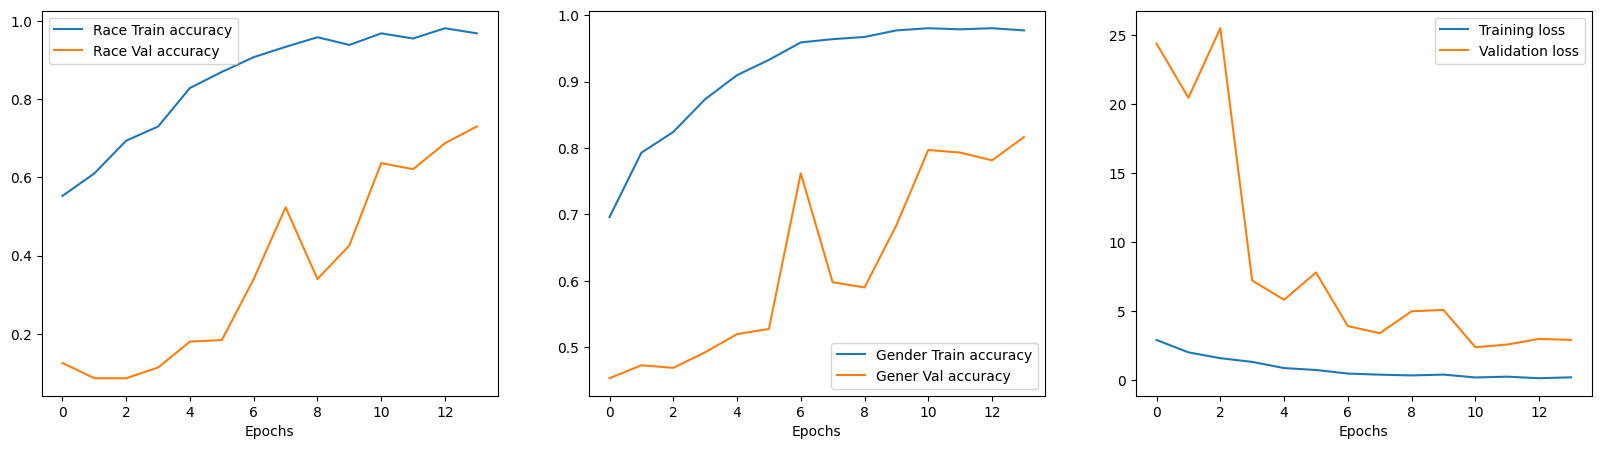

In [8]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()


    axes[2].plot(history.history['loss'], label='Training loss')
    axes[2].plot(history.history['val_loss'], label='Validation loss')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

plot_train_history(history)



In [9]:
# for unfair testing 

test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=16)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//16)))

/tmp/ipykernel_4193/867736833.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//16)))


{'loss': 3.113416910171509,
 'race_output_loss': 1.4478178024291992,
 'gender_output_loss': 0.9416900277137756,
 'race_output_accuracy': 0.75,
 'gender_output_accuracy': 0.8229166865348816}

In [10]:
# for unfair testing
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=16)
x_test, (race_true, gender_true)= next(test_gen)
race_pred, gender_pred = model.predict_on_batch(x_test)


race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1

    accuracy                           0.75        16
   macro avg       0.37      0.38      0.38        16
weighted avg       0.70      0.75      0.72        16


Classification report for gender
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.86      0.67      0.75         9

    accuracy                           0.75        16
   macro avg       0.76      0.76      0.75        16
weighted avg       0.77      0.75      0.75        16



/home/mahdi/FairnessLens/PreProcessor/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahdi/FairnessLens/PreProcessor/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahdi/FairnessLens/PreProcessor/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [13]:
p_t = np.random.permutation(len(test_df))
test_index = p_t[:]
len(test_index)
test_df['gender_id'] = test_df['gender'].map(lambda gender: gender)
test_df['race_id'] = test_df['race'].map(lambda race: race)

In [14]:
test_gen = get_data_generator(test_df, test_index, for_training=False, batch_size=16)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_index)//16)))

/tmp/ipykernel_4193/1964998669.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_index)//16)))


{'loss': 14.118294715881348,
 'race_output_loss': 8.737601280212402,
 'gender_output_loss': 1.011892557144165,
 'race_output_accuracy': 0.22159090638160706,
 'gender_output_accuracy': 0.8238636255264282}

In [15]:
test_gen = get_data_generator(test_df, test_index, for_training=False, batch_size=16)
x_test, (race_true, gender_true)= next(test_gen)
race_pred, gender_pred = model.predict_on_batch(x_test)

In [16]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

In [17]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.19      1.00      0.32         3
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         4

    accuracy                           0.19        16
   macro avg       0.04      0.20      0.06        16
weighted avg       0.04      0.19      0.06        16


Classification report for gender
              precision    recall  f1-score   support

           0       0.69      1.00      0.82         9
           1       1.00      0.43      0.60         7

    accuracy                           0.75        16
   macro avg       0.85      0.71      0.71        16
weighted avg       0.83      0.75      0.72        16



/home/mahdi/FairnessLens/PreProcessor/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahdi/FairnessLens/PreProcessor/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahdi/FairnessLens/PreProcessor/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif